In [35]:
import numpy as np
import pandas as pd 


from skimage import io

import matplotlib.pyplot as plt

from gabor_filters.gabor_filter import GaborFilter as gb
from gabor_filters.gabor_filter import GaborFilterBank as gbb


import importlib
importlib.reload(gabor_filters.gabor_filter)


from gabor_filters.gabor_filter import GaborFilter as gb
from gabor_filters.gabor_filter import GaborFilterBank as gbb

In [36]:
dfFoldTraining_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_4.csv')
dfFoldTraining_1.index[dfFoldTraining_1['short_filenames'] == "0064-cop_calanoida_ptt.png"].tolist()

[11838]

([], [])

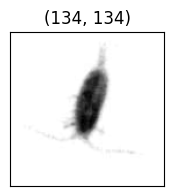

In [37]:
# read an image for testing
img = io.imread(dfFoldTraining_1["filenames"][11838])

plt.figure(figsize=(5,2))

plt.imshow(img,cmap='Greys_r')

plt.title(str(img.shape))
plt.xticks([])
plt.yticks([])

In [38]:
row = img.shape[0]
col = img.shape[1] # size of image
fmax = 0.327 # maximum frequency

k = np.sqrt(2) #frequency ratio or factor for selecting filter frequencies

p = 0.5 # crossing point between two consecutive filters, default 0.5
# pf = np.sqrt(0.99) #energy to include in the filters

u = 6 #number of frequencies
v = 8 #number of orientation

In [39]:

GaborFilterBank = gbb().create_a_set_of_gabor_filters(fmax, k, p, u, v, row, col)

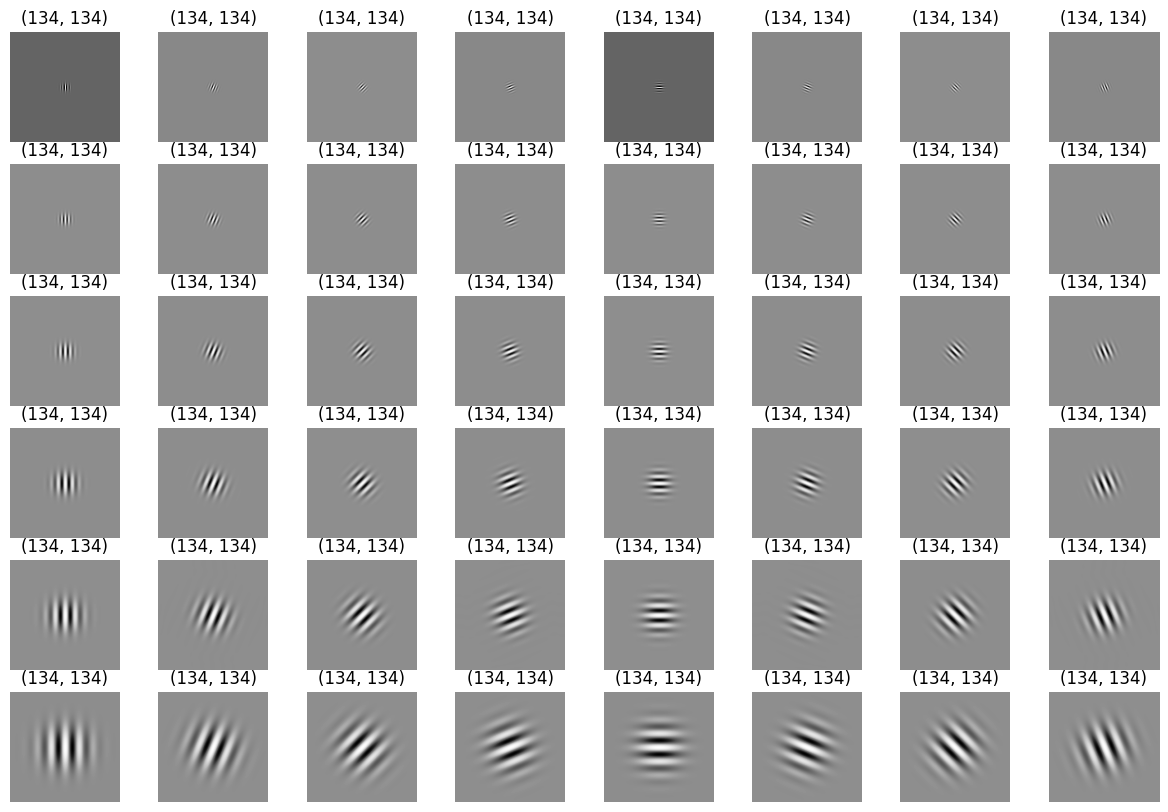

In [40]:
plt.figure(figsize=(15,10)) 
for i in range(len(GaborFilterBank)):
    ax = plt.subplot(u, v, i + 1)
    ax.imshow(np.real(GaborFilterBank[i].SpatialDomainGaborFilter),cmap='Greys_r')
    label = str(np.real(GaborFilterBank[i].SpatialDomainGaborFilter).shape)
    ax.set_title(label)
    ax.axis("off")